In [1]:
########### imports
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy.ndimage as ndimage

from openpmd_viewer import OpenPMDTimeSeries, ParticleTracker

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/mengshutang/desktop/CU_PWFA/COMPUTATIONS/HiPACE/analysis')
import Functions_analysis as fcns

In [2]:
run_name = 'PWFA/cpu_test'
data = '50_cores'

ts = OpenPMDTimeSeries('/Users/mengshutang/Desktop/CU_PWFA/COMPUTATIONS/HiPACE/runs/'+run_name+'/'+data)

In [3]:
iteration = 10

In [4]:
########### read data
n0 = 2e16
charge_d = 1.5e-9 # coulumbs
charge_w = 0.5e-9

Ez, info_Ez = ts.get_field(field = 'Ez',iteration = iteration)
rho, info_rho = ts.get_field(field = 'rho_electron',iteration = iteration)
rho *= 6.25e12/n0

x_d,y_d,z_d,px_d,py_d,pz_d,w_d = ts.get_particle(species = 'driver',iteration = iteration, var_list = ['x','y','z','ux','uy','uz','w'])

x_w,y_w,z_w,px_w,py_w,pz_w,w_w = ts.get_particle(species = 'witness',iteration = iteration, var_list = ['x','y','z','ux','uy','uz','w'])

In [5]:
### check initialization of driver
x,y,z,px,py,pz,w = ts.get_particle(species = 'driver',iteration = 0, var_list = ['x','y','z','ux','uy','uz','w'])
# input
input_emittance = 3.4e-6
a0 = 4.2
b0 = 0.7
g0 = (1+a0**2)/b0
eps0 = input_emittance/19570

# initialized
xp = px/pz
eps = np.sqrt(np.mean(x**2) * np.mean(xp**2) - np.mean(x*xp)**2)
a = -np.mean(x*xp)/eps
g = np.std(xp)**2/eps
b = np.std(x)**2/eps

print(f"initialized twiss a: {np.round(a,3)} (input: {a0}); b:{np.round(b,3)} (input: {b0}); g:{np.round(g,3)} (input: {np.round(g0,3)})")
print(f"initialized x_std: {np.round(np.std(x)*1e6,3)}um (input: {np.round(np.sqrt(eps0*b0)*1e6,3)}); px_std:{np.round(np.std(px),3)} (input: {np.round(19570*np.sqrt(g0*eps0),3)})")
print(f"initialized emittance: {np.round(np.mean(eps*pz)*1e6,3)}um (input: {input_emittance*1e6})")

initialized twiss a: -0.002 (input: 4.2); b:0.001 (input: 0.7); g:999.843 (input: 26.629)
initialized x_std: 2.003um (input: 11.028); px_std:2.003 (input: 1.331)
initialized emittance: 4.013um (input: 3.4)


3450.8330905311


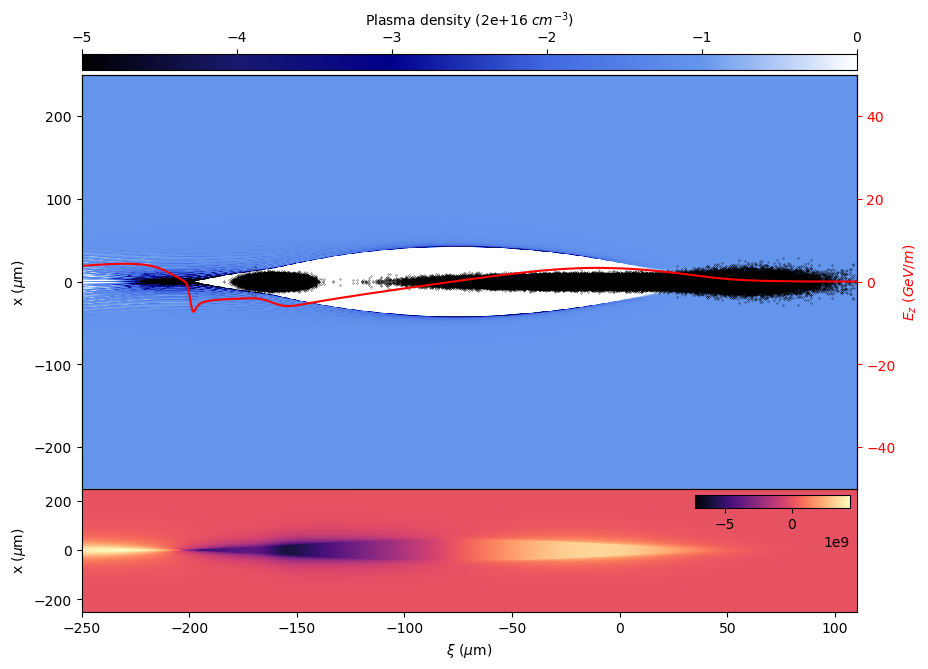

In [6]:
######### plot particles in fields

##### plot settings
fig,(ax1,ax2) = plt.subplots(2,1,sharex = True,figsize = (10,8),gridspec_kw={'height_ratios': [2, 0.5]})
plt.subplots_adjust(wspace=0, hspace=0)
ax2.set_xlabel(r'$\xi$ ($\mu$m)')
ax1.set_ylabel(r'x ($\mu$m)')
ax2.set_ylabel(r'x ($\mu$m)')
ax_E_plot = ax1.twinx()

cmap = plt.cm.hot_r
# cmap = anothercmap
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.linspace(0,1,cmap.N)
# create a new colormap
beam_cmap = ListedColormap(my_cmap)

##### plot plasma density
field_cmap = colors.LinearSegmentedColormap.from_list("", ["Black","midnightblue","darkblue","royalblue","cornflowerblue","white"])

grid_range_z = fcns.cu(info_Ez.z) # in um
grid_range_x = fcns.cu(info_Ez.x) # in um

rho_plot = ax1.pcolormesh(grid_range_z, grid_range_x, np.transpose(rho),cmap = field_cmap, vmin = -5, vmax = 0)
cb_field = plt.colorbar(rho_plot, location='top', aspect=50, pad=0.01,label = f'Plasma density ({n0}'+r" $cm^{-3}$)")
cb_field.set_ticks([0, -1, -2, -3, -4, -5])

##### driver and witness bunch

#Zd, xedges_d, yedges_d = fcns.plot_beam_density(x_d,z_d,charge_d,n0,[200,200],300)
#Zd = ndimage.gaussian_filter(Zd, sigma=1, order=0)
#driver = ax1.pcolormesh(xedges_d, yedges_d, Zd.T, cmap= beam_cmap, vmin=0, vmax=round(np.max(Zd.T), 0))

#Zw, xedges_w, yedges_w = np.histogram2d(z_w*1e6, x_w*1e6, bins=[100,100])
#Zw = ndimage.gaussian_filter(Zw, sigma=1, order=0)
#witness = ax1.pcolormesh(xedges_w, yedges_w, Zw.T, cmap= beam_cmap, vmin=0, vmax=round(np.max(Zw.T), 0))

#cb_beam = plt.colorbar(driver, ax=ax1, location='right', aspect=50, pad=0.1)

ax1.scatter(fcns.cu(z_d),fcns.cu(x_d),s = 0.02,c = 'k')
ax1.scatter(fcns.cu(z_w),fcns.cu(x_w),s = 0.02,c = 'k')

##### plot central Ez field
Ez_center = ts.get_field(field='Ez', iteration=iteration, slice_across='x')[0]
Ez_center = Ez_center/10**9

ax_E_plot.plot(grid_range_z,Ez_center, c='r')

ax_E_plot.yaxis.label.set_color('red')
ax_E_plot.set(ylabel=r"$E_z$ $(GeV/m)$")
ax_E_plot.tick_params(axis='y', colors='r')

# put zero in the middle of the axis
Ez_abs_max = abs(max(ax_E_plot.get_ylim(), key=abs))
ax_E_plot.set_ylim(ymin=-50, ymax=50)

##### plot E field in ax2
E_field_plot = ax2.pcolormesh(grid_range_z, grid_range_x, np.transpose(Ez),cmap = 'magma')

cbaxes = inset_axes(ax2, width="20%", height="10%", loc=1) 
cb_E = plt.colorbar(E_field_plot,cax=cbaxes, orientation='horizontal')

print(ts.t[fcns.find_index(ts,iteration)]*3*10**8*10**6)
#plt.tight_layout()
plt.savefig(f'/Users/mengshutang/Desktop/two_bunch_{iteration}.png',dpi = 300)

/var/folders/1_/d86r7cfn7nbb663qcn5ld6qr0000gn/T/ipykernel_88113/2737159292.py:26: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for level, line in zip(contour.levels, contour.collections):


Text(0.5, 1.0, 'L = 0.35 cm')

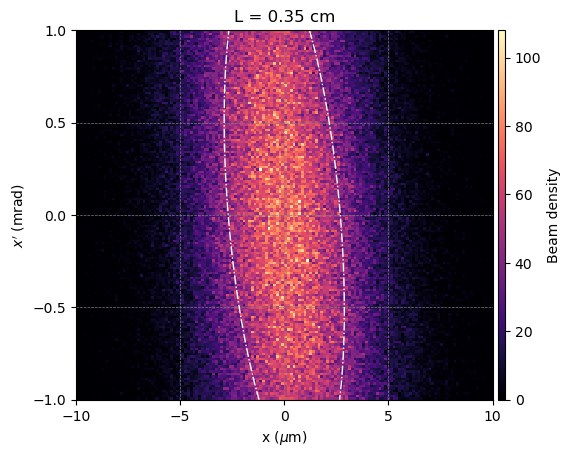

In [7]:
######## plot trace space profile for witness bunch
## ax1 (top panel) indicates beam density in trace space
## ax2 (bottom panel) displays fractional momentum deviation

fig,ax1 = plt.subplots(1,1)
plt.subplots_adjust(wspace=0, hspace=0.1)

x_prime = px_w/pz_w * 10**3
x = x_w*10**6
alpha, beta, gamma = fcns.twiss_params(x,x_prime)
emit_ts = fcns.ts_emittance_rms(x,x_prime)

##### ax1
# beam density histogram
H, xedges, yedges = np.histogram2d(x, x_prime, bins=[150,150],range=[[-10, 10], [-1, 1]])

beam = ax1.pcolormesh(xedges, yedges, H.T, cmap='magma')
cb_beam = plt.colorbar(beam, ax=ax1, location='right', aspect=50, pad=0.01,label = 'Beam density')

# ellipse in trace space
xrange = np.linspace(xedges[0], xedges[-1], 10**3)
yrange = np.linspace(yedges[0], yedges[-1], 10**3)

X, Y, Z = fcns.plot_params_ts_ellipse(xrange, yrange, emit_ts, alpha, beta, gamma)
contour = ax1.contour(X, Y, Z, levels=[0], colors='white')
for level, line in zip(contour.levels, contour.collections):
    line.set_linestyle('dashdot') 
    line.set_linewidth(1) 
    
ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax1.set_xticks(np.linspace(-10,10,num = 5))
ax1.set_yticks(np.linspace(-1,1,num = 5))

ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel(r'$x^{\prime}$ (mrad)')

ax1.set_title(f"L = {np.round(ts.t[fcns.find_index(ts,iteration)]*3*10**8*10**2,2)} cm")

#plt.savefig(f'../Temp plots/w_emit_{iteration}.png',dpi = 300)